In [1]:
import numpy as np
from mc_ic import MC_IC

In [4]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim
from dmp_ic import DMP_IC

import time
t0 = time.time()

T.cuda.set_device(1)

net_path = "../data/test_graph/NetHEPT.npy"
#net_path = "data/BA_500.npy"
#net_path = "data/baseline.npy"
IC = DMP_IC(net_path)

# Penal

In [5]:
def Penal_K(k, lr=0.01, iter=100, rand=False):
    K=k
    if not rand:
        S = T.zeros(IC.N, requires_grad=True)
        opt = optim.SGD([S], lr=lr)
        #opt = optim.Adam([S], lr=lr)

    else:
        S = T.randn(IC.N, requires_grad=True)
        opt = optim.SGD([S], lr=lr)
        #S = S/10

    

    INF = []
    LOSS = []
    LOSS_min = 1E+10
    Patient = 10
    
    for i in range(1, iter):
        opt.zero_grad()
        
        Seed = T.sigmoid(S)

        Sigmas =IC.run(Seed)

        loss = -Sigmas[-1] + T.pow(Seed.sum()-K, 2)
        loss.backward()
        opt.step()
        
        LOSS.append(loss.item())
        
        idx = T.argsort(Seed, descending=True)
        seed_list = idx[:K]

        inf = MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]
        print(inf)
        INF.append(inf)

    # Final...
    Seed = T.sigmoid(S)
    idx = T.argsort(Seed, descending=True)
    seed_list = idx[:K].tolist()
    INF.append(MC_IC(net_path, seed_list, mc=1000)[-1])
    return seed_list, INF, LOSS, Seed.tolist()

## Ex over Lr

In [ ]:
penal_log_10_lr = []
for k in range(1, 51, 2):
    lr_log = []
    for lr in [1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]:
        print("***", k, "***", lr)
        lr_log.append(Penal_K(k, lr=lr, iter=10))
    penal_log_10_lr.append(lr_log)
    
penal_log_10_lr_sigma = [[max(log_lr[1]) for log_lr in log_k] for log_k in penal_log_10_lr]
penal_log_10_lr_sigma_max = [max(s) for s in penal_log_10_lr_sigma]

*** 1 *** 0.1
1.765
1.78
1.704
1.732
1.785
1.748
1.773
1.782
1.764
*** 1 *** 0.01
1.803
91.839
91.616
92.078
91.545
92.28
92.588
91.927
90.888
*** 1 *** 0.001
1.779
91.419
92.609
90.018
92.708
91.88
91.038
91.233
92.009
*** 1 *** 0.0001
1.805
91.799
91.277
90.244
92.241
92.105
92.122
92.615
92.213
*** 1 *** 1e-05
1.756
92.77
92.65
92.543
92.771
91.574
92.624


In [ ]:
penal_log_10_lr_sigma

In [ ]:
penal_log_10_lr_sigma_max

In [ ]:
plt.figure(figsize=(10,20))
plt.plot(np.array(penal_log_10_lr_sigma))
plt.plot(penal_log_10_lr_sigma_max)

plt.legend(["lr="+str(lr) for lr in [1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]])
plt.show()

# Degree

In [32]:
out_weight_degree = IC.out_weight_d
idx = T.argsort(out_weight_degree, descending=True)

wd_log = []
for k in range(1, 51, 2):
    seed_list = idx[:k]
    wd_log.append([seed_list, MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]])

# IMM

In [5]:
base_lines = []
with open("imm_range.txt", "r") as f:
    for line in f.readlines():
        line = line.strip("\n")
        line = line.strip("[")
        line = line.strip("]")
        line = line.split(",")
        line = [int(i) for i in line]
        base_lines.append(line)

FileNotFoundError: [Errno 2] No such file or directory: 'imm_range.txt'

In [30]:
imm_log = []
for k in range(1, 51, 2):
    imm_log.append(MC_IC(net_path, base_lines[k-1], mc=1000)[-1])

# PLT

In [21]:
import pickle as pkl
with open("lr_sigma_max.pkl", "rb") as f:
    lr_sigma_max = pkl.load(f)

In [24]:
import matplotlib.pyplot as plt

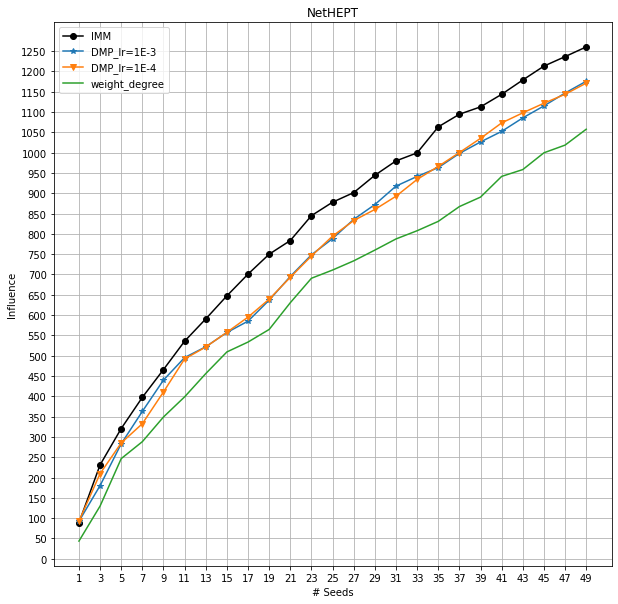

In [73]:
x = range(1, 51, 2)
plt.figure(figsize=(10, 10))
plt.plot(x, imm_log, marker="o", c="k")
plt.plot(x, [y[2] for y in lr_sigma], marker="*")
plt.plot(x, [y[3] for y in lr_sigma], marker="v")
plt.plot(x, [y[1] for y in wd_log])

plt.xticks(x)
plt.yticks(range(0, 1300, 50))
plt.legend(["IMM", "DMP_lr=1E-3","DMP_lr=1E-4", "weight_degree"])
plt.xlabel("# Seeds")
plt.ylabel("Influence")

plt.title("NetHEPT")
plt.grid(True)
plt.show()

In [61]:
import pickle as pkl
with open("lr_sigma.pkl", "rb") as f:
    lr_sigma = pkl.load(f)

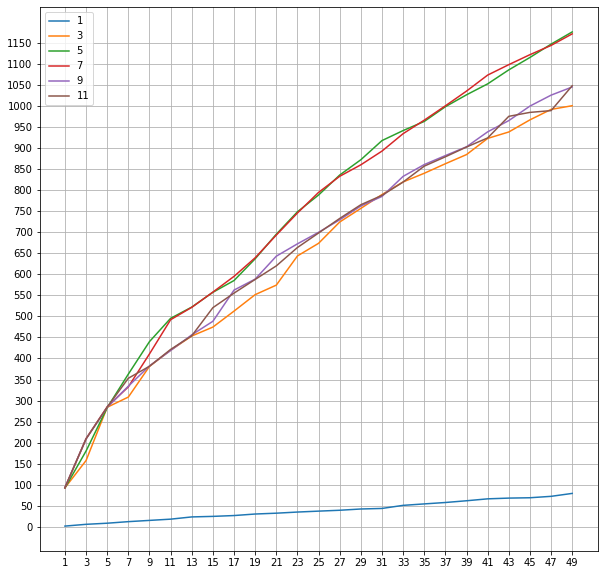

In [71]:
plt.figure(figsize=(10, 10))
plt.plot(x, lr_sigma)

plt.xticks(x)
plt.yticks(range(0, 1200, 50))
plt.legend(x)
plt.grid(True)
plt.show()